In [123]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [124]:
data_raw = pd.read_csv("AMZN.csv")
data_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [125]:
data_raw = data_raw[['Date', 'Close']]

In [126]:
data_raw['Date'] = pd.to_datetime(data_raw['Date'])

/tmp/ipykernel_66080/2511175736.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


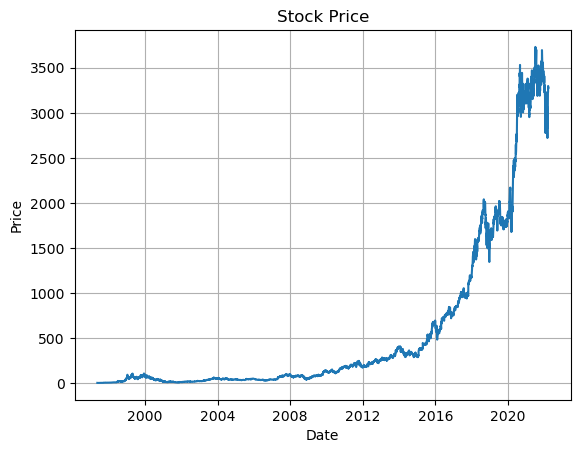

In [127]:
fig, ax = plt.subplots(1, 1)
ax.plot(data_raw['Date'], data_raw['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Stock Price')
ax.grid(visible=True)
fig.show()
fig.savefig('Graphs/Stock.png')

In [128]:
data = np.array(data_raw['Close'])
final_Data = []

for i in range(len(data) - 7):
    final_Data.append(data[i:i+8])

data = np.array(final_Data)

In [129]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [130]:
X = data[:, :-1]
Y = data[:, -1]

In [131]:
split_index = int(X.shape[0] * 0.8)

In [132]:
x_train = X[:split_index]
x_test = X[split_index:]
y_train = Y[:split_index]
y_test = Y[split_index:]

In [133]:
x_train = x_train.reshape((-1, 7, 1))
x_test = x_test.reshape((-1, 7, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [134]:
x_train = torch.Tensor(x_train).float()
x_test = torch.Tensor(x_test).float()
y_train = torch.Tensor(y_train).float()
y_test = torch.Tensor(y_test).float()

In [135]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

training_data = Data(x_train, y_train)
testing_data = Data(x_test, y_test)

In [136]:
batch_size = 32
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

In [137]:
device = ('cuda' if torch.cuda.is_available()
          else 'mps' if torch.backends.mps.is_available()
          else 'cpu')

In [138]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, device):
        super().__init__()
        self.device = device
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.Dense = nn.Linear(hidden_size, output_size)

        nn.ModuleList([self.lstm, self.Dense])
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.Dense(out[:, -1, :])
        return(out)

In [139]:
model = LSTM(1, 32, 1, 2, device).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [140]:
def train(model, optimizer, loss_fn, data_loader):
    model.train(True)
    loss_sum = 0
    m = len(data_loader)

    for i,(x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = loss_sum/m
    return(avg_loss)

In [141]:
num_epochs = 20
loss_list = []
for epoch in range(num_epochs):
    l = train(model, optimizer, loss_fn, train_loader)
    loss_list.append(l)
    print(f'Epoch : {epoch}\tLoss:{l}')

Epoch : 0	Loss:0.03546002434839489
Epoch : 1	Loss:0.0004562290852069506
Epoch : 2	Loss:6.327650437455374e-05
Epoch : 3	Loss:5.585575149056078e-05
Epoch : 4	Loss:5.381887186923699e-05
Epoch : 5	Loss:4.224690364877738e-05
Epoch : 6	Loss:4.833496301205069e-05
Epoch : 7	Loss:3.778174555965011e-05
Epoch : 8	Loss:5.7062389839250206e-05
Epoch : 9	Loss:5.548566519548771e-05
Epoch : 10	Loss:6.108619069723578e-05
Epoch : 11	Loss:6.287315526009432e-05
Epoch : 12	Loss:8.734307902199895e-05
Epoch : 13	Loss:5.1252241554008434e-05
Epoch : 14	Loss:6.003375337215379e-05
Epoch : 15	Loss:5.101737381021843e-05
Epoch : 16	Loss:5.183818692188605e-05
Epoch : 17	Loss:8.844084815247038e-05
Epoch : 18	Loss:8.802094491364385e-05
Epoch : 19	Loss:6.784990052443727e-05


/tmp/ipykernel_66080/250614119.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


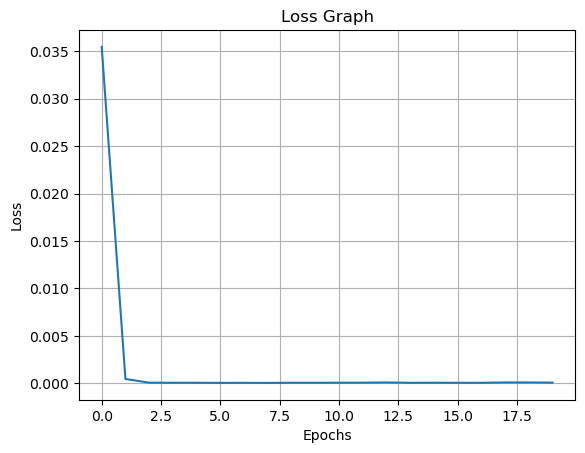

In [142]:
epoch_range = list(range(20))
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_range, loss_list)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss Graph')
ax.grid(visible=True)
fig.show()
fig.savefig('Graphs/Loss.png')

/tmp/ipykernel_66080/1758799471.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


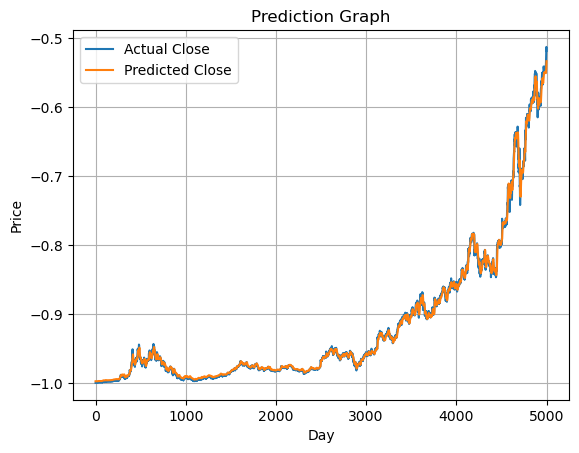

In [143]:
with torch.no_grad():
    x_train = x_train.to(device)
    predicted = model(x_train).to('cpu').numpy()

fig, ax = plt.subplots(1, 1)
ax.plot(y_train, label='Actual Close')
ax.plot(predicted, label='Predicted Close')
ax.set_xlabel('Day')
ax.set_ylabel('Price')
ax.set_title('Prediction Graph')
ax.legend()
ax.grid(visible=True)
fig.show()
fig.savefig('Graphs/Prediction.png')